# Imports

In [1]:
from copy import deepcopy
import numpy as np
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from collections import OrderedDict

%matplotlib inline

# Chargement des données

In [2]:
def loadData(dir="./data/", university="cornell"):
    fcontent = open(dir+"content/"+university+".content", "r")
    content = OrderedDict()
    labels = set()
    for l in fcontent.readlines():
        attributes = l.split('\t')
        label = attributes[-1][:-1]
        labels.add(label)
        content[attributes[0]] = {}
        content[attributes[0]]['attributes'] = attributes[1:-1]
        content[attributes[0]]['label'] = label
        content[attributes[0]]['successors'] = set()
        content[attributes[0]]['predecessors'] = set()
        content[attributes[0]]['neighbours'] = set()
        content[attributes[0]]['unknown'] = False
    fcontent.close()
    fcites = open(dir+"cites/"+university+".cites", "r")
    for l in fcites.readlines():
        sites = l[:-1].split(' ')
        content[sites[0]]['successors'].add(sites[1])
        content[sites[1]]['predecessors'].add(sites[0])
        content[sites[0]]['neighbours'].add(sites[1])
        content[sites[1]]['neighbours'].add(sites[0])
    return content, list(labels)

# Creation des features pour le classifieur local

In [3]:
def vectorize(graph, unknownList, classes, pooling='sum', direction='successors'):
    nNodes = len(graph.keys())
    nAtt = len(graph[graph.keys()[0]]['attributes'])
    nClass = len(classes)
    nUnknown = len(unknownList)
    representation = {}
    representation['unknown'] = np.zeros((nUnknown, nAtt + nClass))
    representation['known'] = np.zeros((nNodes - nUnknown, nAtt + nClass))
    labels = {}
    labels['unknown'] = np.zeros(nUnknown)
    labels['known'] = np.zeros(nNodes - nUnknown)
    i = {}
    i['unknown'] = 0
    i['known'] = 0
    for node in graph:
        if (node in unknownList):
            k = 'unknown'
            #si unknownList n'est pas trié
            #i[k] = unknownList.index(node)
        else:
            k = 'known'
        representation[k][i[k],:nAtt] = graph[node]['attributes']
        labels[k][i[k]] = classes.index(graph[node]['label'])
        nKnownSuccessors = 0
        for s in graph[node][direction]:
            if (not graph[s] in unknownList):
                nKnownSuccessors += 1
                labelIndex = classes.index(graph[s]['label'])
                if (pooling == 'sum' or pooling == 'avg'):
                    representation[k][i[k],nAtt + labelIndex] += 1
                if (pooling == 'max'):
                    representation[k][i[k],nAtt + labelIndex] = 1
        if (pooling == 'avg' and nKnownSuccessors > 0):
            representation[k][i[k],nAtt:] /= nKnownSuccessors
        i[k] += 1
    return representation, labels

def revectorize(graph, node, classes, pooling='sum', direction='successors'):
    nAtt = len(graph[node]['attributes'])
    nClass = len(classes)
    representation = np.zeros(nAtt + nClass)
    representation[:nAtt] = graph[node]['attributes']
    nKnownSuccessors = len(graph[node][direction])
    for s in graph[node][direction]:
        labelIndex = classes.index(graph[s]['label'])
        if (pooling == 'sum' or pooling == 'avg'):
            representation[nAtt + labelIndex] += 1
        if (pooling == 'max'):
            representation[nAtt + labelIndex] = 1
    if (pooling == 'avg' and nKnownSuccessors > 0):
        representation[nAtt:] /= nKnownSuccessors
    return representation

# ICA

In [4]:
class ICA():
    def __init__(self, localClf, pooling='sum', maxIter=500):
        self.localClf = localClf
        self.pooling = pooling
        self.maxIter = maxIter
        pass
    def predict(self, graph, unknown, classes):
        data, label = vectorize(graph, unknown, classes, self.pooling)
        self.localClf.fit(data["known"], label["known"])
        currentPred = self.localClf.predict(data["unknown"])
        for i,u in enumerate(unknown):
            graph[u]['label'] = classes[int(currentPred[i])]
        newPred = np.zeros(currentPred.shape)
        stop = False
        for k in xrange(self.maxIter):
            for i in np.random.permutation(len(unknown)):
                node = unknown[i]
                newPred[i] = self.localClf.predict(revectorize(g, node, classes, self.pooling))
                g[node]['label'] = classes[int(newPred[i])]
            if ((currentPred == newPred).mean() == 1):
                break
            tmp = newPred
            newPred = currentPred
            currentPred = tmp
        return currentPred

# Propagation de labels

In [5]:
class LabelPropagation():
    def __init__(self):
        pass
    def predict(self):
        pass

# Experimentations

## Chargement des données

In [6]:
graph, classes = loadData()

# Selection des labels inconnus
pUnknown = .10

unknown = np.array(graph.keys())[np.sort((np.random.permutation(len(graph.keys()))[:int(len(graph.keys())*pUnknown)]))]

## Classifieur local

In [7]:
# Extraction des features
data, label = vectorize(graph, unknown, classes, 'sum')

classifierLocal = LinearSVC(C=1e-2)
classifierLocal.fit(data["known"], label["known"])
pred = classifierLocal.predict(data["unknown"])
print "Score:", (pred == label["unknown"]).mean()

Score: 0.789473684211


## ICA

In [8]:
g = deepcopy(graph)

ica = ICA(LinearSVC(C=1e-2))
pred = ica.predict(g, unknown, classes)
print "Score: ", (pred == label['unknown']).mean()

Score:  0.789473684211


## Propagation de labels

In [ ]:
class LabelPropagation():
    def __init__(self, beta=2e-2, lambd=1e-2, eps=1e-4, maxIter=2000):
        self.beta = beta
        self.lambd = lambd
        self.eps = eps
        self.maxIter = maxIter
    def predict(self, graph, unknown, classes):
        pass

## En fonction de la proportion de labels inconnus

In [9]:
listP = np.arange(0.05,.96,.01)
nbExp = 10
scoreLocal = np.zeros((len(listP), nbExp))
scoreICA = np.zeros((len(listP), nbExp))

for i,pUnknown in enumerate(listP):
    for k in xrange(nbExp):
        unknown = np.array(graph.keys())[np.sort((np.random.permutation(len(graph.keys()))[:int(len(graph.keys())*pUnknown)]))]
        # Classifieur Local
        data, label = vectorize(graph, unknown, classes, 'sum')
        classifierLocal = LinearSVC(C=1e-2)
        classifierLocal.fit(data["known"], label["known"])
        predLocal = classifierLocal.predict(data["unknown"])
        scoreLocal[i][k] = (predLocal == label["unknown"]).mean()
        # ICA
        g = deepcopy(graph)
        ica = ICA(LinearSVC(C=1e-2))
        predICA = ica.predict(g, unknown, classes)
        scoreICA[i][k] = (predICA == label["unknown"]).mean()

-0.000454274985455


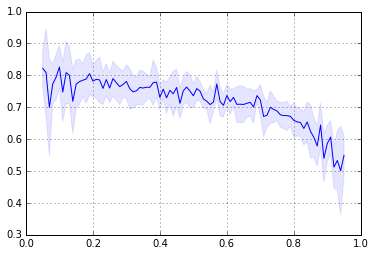

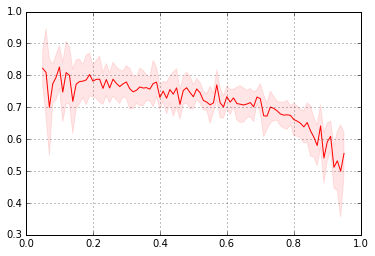

In [15]:
plt.figure()
plt.grid()

plt.plot(listP, scoreLocal.mean(1), '-', color='b')
plt.fill_between(listP, scoreLocal.mean(1) - scoreLocal.std(1), scoreLocal.mean(1) + scoreLocal.std(1), alpha=0.1, color="b")

plt.figure()
plt.grid()
plt.plot(listP, scoreICA.mean(1), '-', color='r')
plt.fill_between(listP, scoreICA.mean(1) - scoreICA.std(1), scoreICA.mean(1) + scoreICA.std(1), alpha=0.1, color="r")

print (scoreICA - scoreLocal).mean()